In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import safe
import torch
import datamol as dm
import types
from molfeat.trans.pretrained import PretrainedMolTransformer
from molfeat.trans.pretrained import PretrainedHFTransformer

from molfeat.trans.pretrained.hf_transformers import HFModel
from safe.trainer.model import SAFEDoubleHeadsModel
from safe.tokenizer import SAFETokenizer


## Loading the SAFE-GPT model into molfeat

Because the SAFE model is not a standard HuggingFace `transformers` model, we need to wrap it.

Why are we doing this ? Because we want to leverage the structure of `molfeat` and not have to write our own pooling for the model. This can be done by using the huggingface molecule transformer `PretrainedHFTransformer`  rather than the general purpose pretrained model class `PretrainedMolTransformer` where we will have to define our own `_embed` and `_convert` function.

In [3]:
safe_model = SAFEDoubleHeadsModel.from_pretrained("datamol-io/safe-gpt")
safe_tokenizer = SAFETokenizer.from_pretrained("datamol-io/safe-gpt")

We now need to build the `molfeat`'s `HFModel` instance by wrapping our model.

In [4]:
safe_hf_model = HFModel.from_pretrained(safe_model, safe_tokenizer.get_pretrained())

You can put the above process in the `__init__` of the `SAFEMolTransformer` if you wish as we will be doing below.

## Building the SAFE Molecule Transformers

We have multiple options here, we can override the `_convert` method or even the `_embed` method but the best thing about `molfeat` is how flexible it is and all the shortcuts it provides. 

In this case, we just need to change the custom 
# so really we just need our custom converter

In [20]:
class SAFEMolTransformer(PretrainedHFTransformer):
    """Build the SAFE Molecule transformers, the only thing we need to define is 
    how we convert the input molecules into the safe format"""
    def __init__(self, kind=None, notation="safe", **kwargs):
        if kind is None:
            # we load the default SAFE model if the exact SAFE GPT model 
            # to use is not provided
            safe_model = SAFEDoubleHeadsModel.from_pretrained("datamol-io/safe-gpt")
            safe_tokenizer = SAFETokenizer.from_pretrained("datamol-io/safe-gpt")
            kind = HFModel.from_pretrained(safe_model, safe_tokenizer.get_pretrained())
        super().__init__(kind, notation=None, **kwargs)
        # now we change the internal converter
        # overriding the internal converter of SmilesConverter leverages the exception handling
        # The SAFE-GPT model was trained on a slightly different splitting algorithm compared to the default BRICS
        # this does not change anything in theory, it just try harder to break bonds even if there are no BRICS bonds.
        self.converter.converter = types.SimpleNamespace(decode=safe.decode, encode=safe.utils.convert_to_safe)
        # you could also do any of the following:
        # self.converter = types.SimpleNamespace(decode=safe.decode, encode=safe.encode)
        # self.converter = safe # the safe module


2023-12-20 22:57:39.310 | WARNING  | molfeat.trans.base:__init__:51 - The 'SAFEMolTransformer' interaction has been superseded by a new class with id 0x2ad77d6a0


Let's use the GPT pooler which uses the last non padding token (often `eos`) since the model is GPT2 like. For other options, see: https://molfeat-docs.datamol.io/stable/api/molfeat.utils.html#pooling

In [98]:
# Let's use the GPT pooling method
safe_transformers = SAFEMolTransformer(pooling="gpt")
safe_transformers

SAFEMolTransformer(dtype=np.float32)

In [99]:
mols = dm.data.freesolv().iloc[:10].smiles.values

In [100]:
safe_transformers(mols)

array([[ 0.05216356,  0.10754181,  0.07509107, ...,  0.04756968,
        -0.08228929, -0.11568106],
       [ 0.02449008,  0.04048932,  0.14489463, ...,  0.11410899,
        -0.02203353,  0.08706839],
       [-0.07425696,  0.11859665,  0.19010407, ...,  0.10526019,
         0.08878426, -0.06609854],
       ...,
       [ 0.07867863,  0.19300285,  0.23054805, ..., -0.00737952,
         0.07542405,  0.00289541],
       [ 0.12092628, -0.01785688,  0.19791883, ...,  0.13796932,
         0.11520796, -0.15333697],
       [-0.02005584,  0.13946685,  0.18568742, ...,  0.07080407,
         0.06991849, -0.07151204]], dtype=float32)

### Basic Test

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

df = dm.data.freesolv()
df["safe"]  = df["smiles"].apply(safe_transformers.converter.encode)
df = df.dropna(subset="safe")
# we have to remove the molecules that cannot be converted 
# (no breakable bonds with our default methodology)


In [102]:

X, y = df["smiles"].values, df["expt"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25, test_size=0.2)

# The Molfeat transformer seemingly integrates with Scikit-learn Pipeline!
pipe = Pipeline([("feat", safe_transformers), ("rf", RandomForestRegressor())])

In [103]:
with dm.without_rdkit_log():
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    y_pred = pipe.predict(X_test)


In [104]:
print("R2 score", score)

R2 score 0.5082630204054333


Text(0, 0.5, 'Preds')

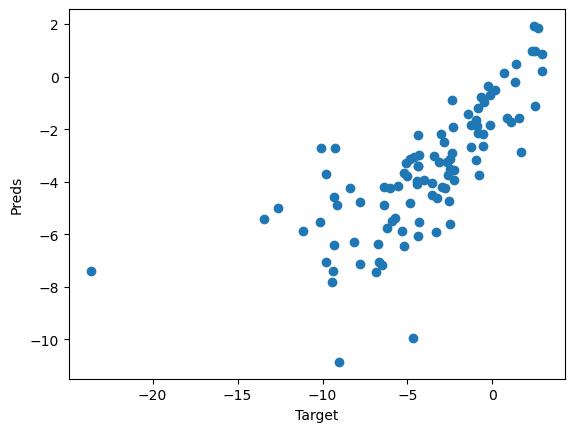

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel("Target")
ax.set_ylabel("Preds")

Not really a great result. Any other model in `molfeat` would do better.

### Tips

1. Make sure that your inputs are SMILES or RDKit Molecules.
2. If you are getting an error coming from some tokenization step, that means that you are likely getting `None` molecules at some steps in the conversion to SAFE. This can happen if there your slicing algorithm of choice is not working. In that case, please filter your datasets to remove molecules that fails the encoding steps first. You can always use the very robus `safe.utils.convert_to_safe`, which augment default BRICS slicing with some graph partitioning algorithm.
